# Reinforcement Learning

In [16]:
import numpy as np
import matplotlib.pyplot as plt

## Model Parameters

In [17]:
#model environment parameters
adjustment_interval_min = 15
charging_duration_min = 120
min_charging_rate_kW = 0
max_charging_rate_kW = 22
battery_capacity_kWh = 40

expected_usage_kWh = 30
sigma_kWh = 5

#optimizer (Reinforcement Learner) parameters
fully_exhousted_penalty = -10_000_000_000 #penalty for charging can get very high itself (-329_703_933)
overcharge_penalty_sqr = 1.7

#computed parameters
num_charging_adjustments = int(charging_duration_min/adjustment_interval_min)


A = [1,1,2,2,2,2,1,1]

print(num_charging_adjustments)
print(A)

8
[1, 1, 1, 1, 1, 1, 1, 1]


In [18]:

def get_charge_demand():
    samples = np.random.normal(expected_usage_kWh, 1, 1)
    return samples[0]
get_charge_demand()


29.79646959634804

In [19]:
def calcChargingCost(t, p):
    e = np.exp(1)
    return A[t]*(e**p)

def rewardF(totalChargeByInterval, requiredkWh):
    totalCharged = totalChargeByInterval/(int(60/adjustment_interval_min))
    # diviation penalty
    overCharge = 0
    if(requiredkWh - totalCharged < 0):
        overCharge = -(int(calcChargingCost(1, abs(requiredkWh - totalCharged))**overcharge_penalty_sqr))
    # extra penalty for running out
    runOutCost = fully_exhousted_penalty if requiredkWh > totalCharged else 0
    return  overCharge + runOutCost

print("Max overcharge", rewardF(178, 30)) #max overcharge
print("Exact Charge", rewardF(120, 30)) #exact charge
print("Medium overcharge", rewardF(150, 30))
print("Low charge", rewardF(110, 30)) #low charge

Max overcharge -50740994964
Exact Charge 0
Medium overcharge -344551
Low charge -10000000000


## Environment Modelling

In [20]:
#generate env

def convertActionToChargingPower(value):
    if value == 0:
        return 0
    if value == 1:
        return 10
    if value == 2:
        return 16
    if value == 3:
        return 22

class env:
    def __init__(self):
        self.nA = 4
        self.desired_charge = get_charge_demand()
        self.nS = self.totalNodes(num_charging_adjustments)
        self.P = self.create_P()
        """ 
        print(self.nS)
        print(self.nA)
        print(self.P) """
        self.current_state = 0

    def reset(self):
        self.desired_charge = get_charge_demand()
        self.current_state = 0
        return np.array([0])
    
    def getActionValues(self, level, levelId):
        actionValue = levelId%self.nA
        values = [actionValue]
        ids = [levelId]
        for lvl in range(0, level):
            lastActionId = ids[0]//self.nA
            lastActionValue = lastActionId%self.nA
            values.insert(0, lastActionValue)
            ids.insert(0, lastActionId)
        return values

    def step(self, action):
        charge, next_state, reward, done = self.P[self.current_state][action][0]
        self.current_state = next_state
        if(done):
            reward = rewardF(charge, self.desired_charge) + reward
        return (np.array([next_state]), reward, done, charge)

    def totalNodes(self, layer):
        totalNodes = 0
        for lvl in range(0, layer):
            totalNodes = totalNodes + self.nA**lvl
        return totalNodes

    
    def create_P(self):
        P = []

        numberOfActions = self.nA

        actions = list()

        states = list()

        print("Actions", self.totalNodes(num_charging_adjustments))

        for actionLevel in range(0, num_charging_adjustments + 1):#+1 because the root of the tree has no pretaken action
            lastLayerActions = self.totalNodes(actionLevel)
            layerActions = self.totalNodes(actionLevel+1)

            states.append([])

            for levelActionId in range(0, numberOfActions**actionLevel):
                # levelActionId:
                #0 0 0 0
                #  1 1 1
                #    2 2
                #      3
                #
                # globalIds:
                #0 1 3 6
                #  2 4 7
                #    5 8
                #      9
                #

                #construct location in state tree
                action = levelActionId%numberOfActions
                globalActionId = (lastLayerActions-1) + levelActionId
                actions.append(0)

                originStateLevelId = levelActionId//numberOfActions
                originStateId = originStateLevelId+self.totalNodes(actionLevel-1)
                destinationStateId = self.totalNodes(actionLevel)+(originStateLevelId*numberOfActions)+action

                if(originStateId == len(P)):
                    P.append([])
                elif(originStateId > len(P)):
                    print("!Skipped state!")


                if(actionLevel != num_charging_adjustments):
                    #get total charging power
                    actionValues = self.getActionValues(actionLevel, levelActionId)
                    #remove root node
                    actionValues = actionValues[1:]
                    charge = 0
                    for i, action in enumerate(actionValues):
                        charge = charge + convertActionToChargingPower(action)
                    rewardValue = 0
                    #limit charge to battery capacity
                    if(charge/4 < battery_capacity_kWh):
                        rewardValue = -(calcChargingCost(actionLevel - 1, convertActionToChargingPower(action))/4)

                    actionTransition = ( charge, destinationStateId, int(rewardValue), False)
                    actions[globalActionId] = actionTransition
                    P[originStateId].append([actionTransition])
                else:
                    #get total charging power
                    actionValues = self.getActionValues(actionLevel, levelActionId)
                    #remove root node
                    actionValues = actionValues[1:]
                    charge = 0
                    for i, action in enumerate(actionValues):
                        charge = charge + convertActionToChargingPower(action)
                    rewardValue = 0
                    #limit charge to battery capacity
                    if(charge/4 < battery_capacity_kWh):
                        rewardValue = -(calcChargingCost(actionLevel - 1, convertActionToChargingPower(action))/4)
                    #rewardValue = rewardF(charge, self.desired_charge) + rewardValue
                    
                    actionTransition = (charge, destinationStateId, int(rewardValue), True)
                    actions[globalActionId] = actionTransition
                    P[originStateId].append([actionTransition])
        #remove root node
        P[0] = P[0][1:]
        return P

env = env()

Actions 21845


## Example Decision Path

In [21]:
# P[n] is the list of states
# each state containes a list of actions P[n][a]
# each action contains a list of tuples like (transition_prob, next_state, reward, done)
# since transition_prob is always 1 there is also only one tuple per action

# take example path

charge_level_test = [0, 0, 3, 2, 2, 2, 2, 2]

totalCharge = 0
for i in range(0, 8):
       totalCharge = totalCharge + convertActionToChargingPower(charge_level_test[i])
totalCharge = totalCharge/4
print("Charged: ", totalCharge)

env.reset()

print(env.desired_charge)

for i in range(0,8):
    next_state, reward, done, charge = env.step(charge_level_test[i])
    print("1. Action: ", next_state, reward, done)


Charged:  25.5
27.943396854118575
1. Action:  [1] 0 False
1. Action:  [5] 0 False
1. Action:  [24] -896228211 False
1. Action:  [99] -2221527 False
1. Action:  [399] -2221527 False
1. Action:  [1599] -2221527 False
1. Action:  [6399] -2221527 False
1. Action:  [25599] -10002221527 True


## Monte-Carlo Control

starting episode 0
starting episode 100000
starting episode 200000
starting episode 300000
starting episode 400000
starting episode 500000
starting episode 600000
starting episode 700000
starting episode 800000
starting episode 900000
starting episode 1000000
starting episode 1100000
starting episode 1200000
starting episode 1300000
starting episode 1400000
starting episode 1500000
starting episode 1600000
starting episode 1700000
starting episode 1800000
starting episode 1900000
getting ready to test policy
AVG Score -909562.887
[2, 2, 2, 3, 2, 1, 2, 2]
[-2221527, -2221527, -2221527, -896228211, -2221527, -5506, -2221527, -2221535]
Charged:  32.0


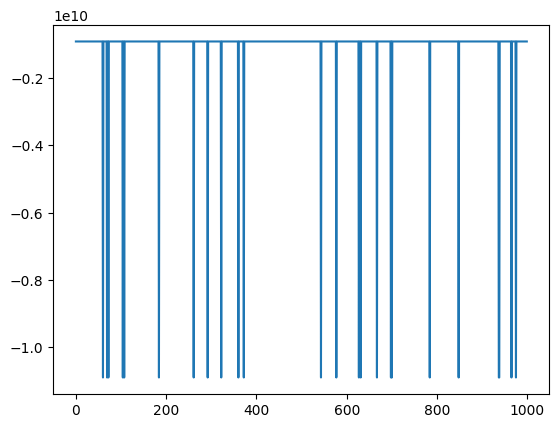

In [22]:
# this algo ignores all but the last rewards


EPS = 0.05
GAMMA = 1.0

Q = {}
actionSpace = [0, 1, 2, 3]

stateSpace = []
returns = {}
pairsVisited = {}

for i in range(0, env.nS):
    for action in actionSpace:
        Q[(i, action)] = 0
        returns[(i, action)] = 0
        pairsVisited[(i, action)] = 0
    stateSpace.append(i)

policy = {}
for state in stateSpace:
    policy[state] = np.random.choice(actionSpace)

numEpisodes = 2_000_000
for i in range(numEpisodes):
    statesActionsReturns = []
    memory = [] # episode memory
    if i % 100000 == 0:
        print('starting episode', i)
    observation = env.reset()
    done = False
    #play one round
    while not done:
        action = policy[observation[0]]
        observation_, reward, done, info = env.step(action)
        memory.append((observation[0], action, reward))
        observation = observation_
    #memory.append((observation[0], action, reward))    

    #accumulative reward from states
    G = 0
    for playerState, action, reward in reversed(memory):
        G = GAMMA*G + reward
        statesActionsReturns.append((playerState, action, G))
        
    statesActionsReturns.reverse()
    statesActionsVisited = []

    for playerState, action, G in statesActionsReturns:
        sa = ((playerState), action)
        if sa not in statesActionsVisited:
            pairsVisited[sa] += 1
            # incremental implementation
            # new estimate = 1 / N * [sample - old estimate]
            returns[(sa)] += (1 / pairsVisited[(sa)])*(G-returns[(sa)])
            Q[sa] = returns[sa]
            rand = np.random.random()
            if rand < 1 - EPS:
                state = (playerState)
                values = np.array([Q[(state, a)] for a in actionSpace ])
                best = np.random.choice(np.where(values==values.max())[0])
                policy[state] = actionSpace[best]
            else:
                policy[state] = np.random.choice(actionSpace)
            statesActionsVisited.append(sa)
    if EPS - 1e-7 > 0:
        EPS -= 1e-7
    else:
        EPS = 0

numEpisodes = 1000
rewards = np.zeros(numEpisodes)
totalReward = 0
avg_reward = 0
print('getting ready to test policy')
last_episode = []
last_ep_rew = []
for i in range(numEpisodes):
    totalReward = 0
    observation = env.reset()
    done = False
    cum_reward = 0
    while not done:
        action = policy[observation[0]]
        observation_, reward, done, info = env.step(action)
        observation = observation_
        if(i == numEpisodes - 1):
            last_episode.append(action)
            last_ep_rew.append(reward)
        cum_reward += reward
    totalReward += cum_reward
    rewards[i] = totalReward
avg_reward = totalReward/numEpisodes
print("AVG Score", avg_reward)
print(last_episode)
print(last_ep_rew)
totalCharge = 0
for i in range(0, 8):
       totalCharge = totalCharge + convertActionToChargingPower(last_episode[i])
totalCharge = totalCharge/4
print("Charged: ", totalCharge)
plt.plot(rewards)
plt.show()    

## Deep-Q Learning

In [257]:
# build the agent
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.optimizers.legacy import Adam

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state)

            q_next = self.q_eval.predict(new_state)

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                                  self.gamma*np.max(q_next, axis=1)*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min

In [258]:
# run learning process
import numpy as np

lr = 0.0005
n_games = 300
agent = Agent(gamma=0.99, epsilon=0.0, alpha=lr, input_dims=1,
                n_actions=4, mem_size=1000000, batch_size=64, epsilon_end=0.0)

scores = []
eps_history = []

#env = wrappers.Monitor(env, "tmp/lunar-lander-6",
#                         video_callable=lambda episode_id: True, force=True)

last_games = []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()
    game = []
    
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.remember(observation, action, reward, observation_, int(done))
        observation = observation_
        agent.learn()
        #ouput the last 5 episodes actions
        if(i > n_games - 6):
            game.append(action)

    if(i > n_games - 6):
        last_games.append(game)

    eps_history.append(agent.epsilon)
    scores.append(score)

    avg_score = np.mean(scores[max(0, i-100):(i+1)])
    print('episode: ', i,'score: %.2f' % score,
            ' average score %.2f' % avg_score)
print(last_games)


1/1 [==============================] - 0s 10ms/step
episode:  0 score: -10000250000.00  average score -10000250000.00
1/1 [==============================] - 0s 7ms/step
episode:  1 score: -10000250000.00  average score -10000250000.00
1/1 [==============================] - 0s 11ms/step
episode:  2 score: -10000250000.00  average score -10000250000.00
1/1 [==============================] - 0s 7ms/step
episode:  3 score: -10000250000.00  average score -10000250000.00
1/1 [==============================] - 0s 11ms/step
episode:  4 score: -10000250000.00  average score -10000250000.00
1/1 [==============================] - 0s 7ms/step
episode:  5 score: -10000250000.00  average score -10000250000.00
1/1 [==============================] - 0s 7ms/step
episode:  6 score: -10000250000.00  average score -10000250000.00
1/1 [==============================] - 0s 7ms/step
episode:  7 score: -10000250000.00  average score -10000250000.00
2/2 [==============================] - 0s 898us/step
episode: